0️⃣ Imports & configuration (identique arduino_tiny_ml)

In [279]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


1️⃣ Chargement et Visualisation des données

Les fichiers CSV issus de l’Arduino (IMU).

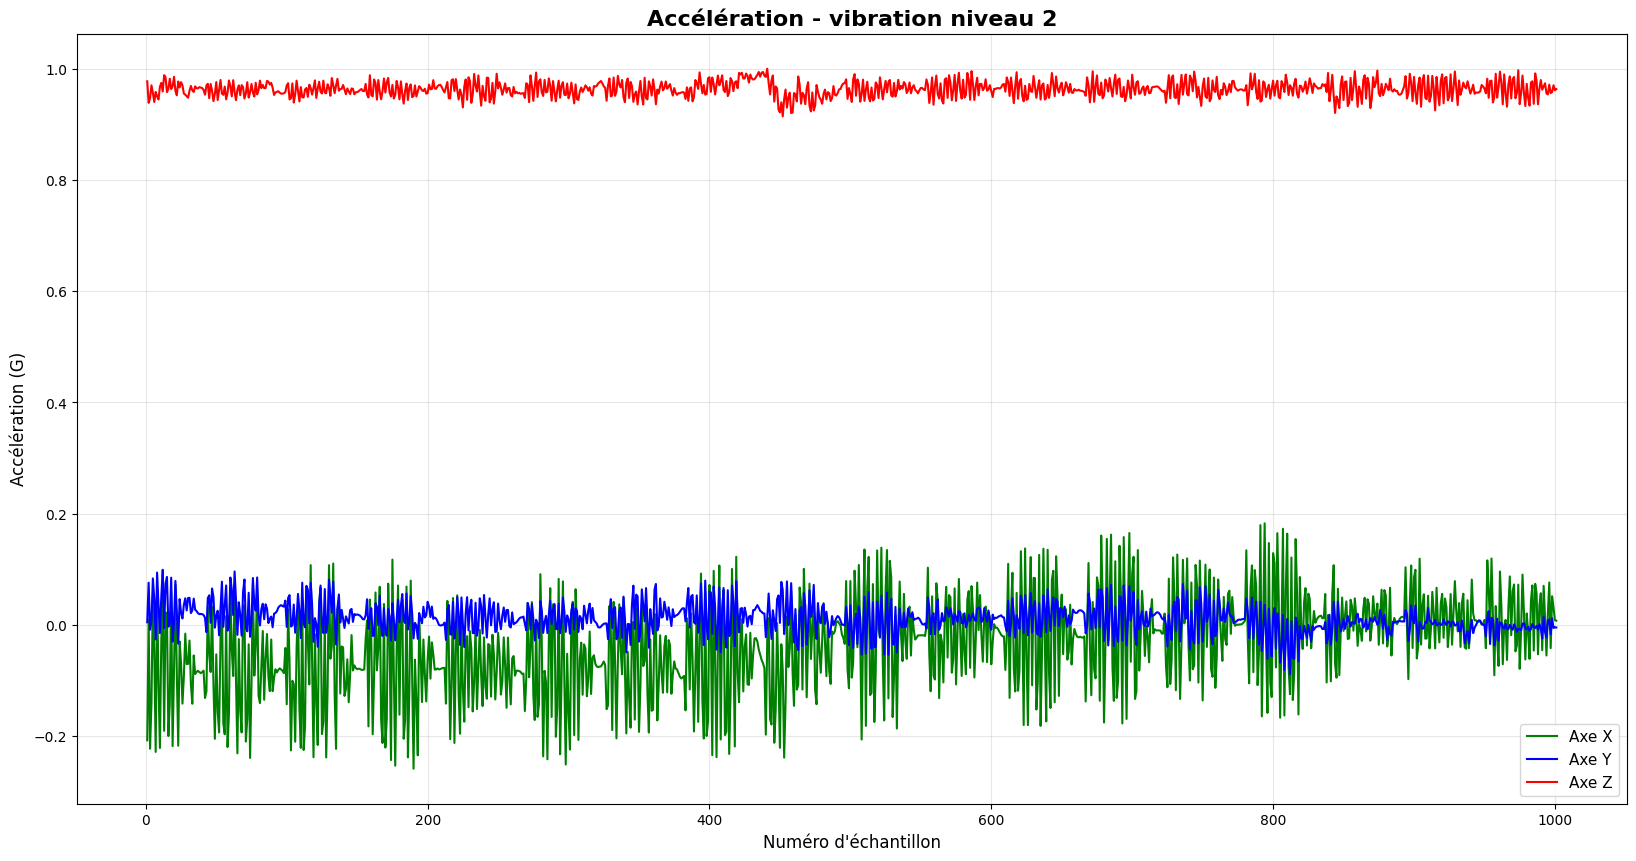

✓ Visualisation terminée. Vous pouvez voir les patterns.


In [280]:
data_class_0 = pd.read_csv("../dataset/vibration_0.csv")
data_class_1 = pd.read_csv("../dataset/vibration_1.csv")
data_class_2 = pd.read_csv("../dataset/vibration_2.csv")


# Créer un index pour l'axe X (numéro d'échantillon)
index = range(1, len(data_class_2['ax']) + 1)

# Définir la taille des graphiques (largeur, hauteur en pouces)
plt.rcParams["figure.figsize"] = (20, 10)

# Graphique 1 : Accélération
# Les couleurs : vert (g) pour X, bleu (b) pour Y, rouge (r) pour Z
plt.plot(index, data_class_2['ax'], 'g-', label='Axe X', linewidth=1.5)
plt.plot(index, data_class_2['ay'], 'b-', label='Axe Y', linewidth=1.5)
plt.plot(index, data_class_2['az'], 'r-', label='Axe Z', linewidth=1.5)
plt.title("Accélération - vibration niveau 2", fontsize=16, fontweight='bold')
plt.xlabel("Numéro d'échantillon", fontsize=12)
plt.ylabel("Accélération (G)", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print("✓ Visualisation terminée. Vous pouvez voir les patterns.")



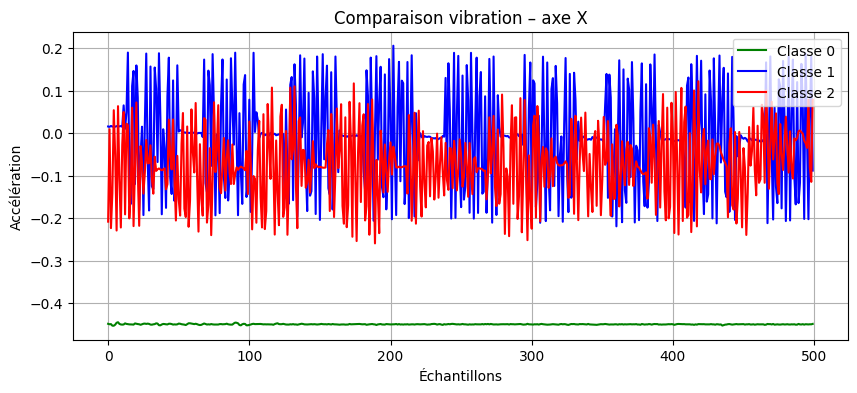

In [281]:
plt.figure(figsize=(10,4))
plt.plot(data_class_0["ax"][:500], 'g-', label="Classe 0")
plt.plot(data_class_1["ax"][:500], 'b-', label="Classe 1")
plt.plot(data_class_2["ax"][:500], 'r-', label="Classe 2")
plt.title("Comparaison vibration – axe X")
plt.xlabel("Échantillons")
plt.ylabel("Accélération")
plt.legend()
plt.grid()
plt.show()


In [282]:
WINDOW_SIZE = 50
N_FEATURES = 3

def create_windows_per_class(df, label, window_size):
    Xw, yw = [], []
    Xc = df[["ax", "ay", "az"]].values

    for i in range(len(Xc) - window_size):
        Xw.append(Xc[i:i+window_size])
        yw.append(label)

    return np.array(Xw), np.array(yw)

X0, y0 = create_windows_per_class(data_class_0, 0, WINDOW_SIZE)
X1, y1 = create_windows_per_class(data_class_1, 1, WINDOW_SIZE)
X2, y2 = create_windows_per_class(data_class_2, 2, WINDOW_SIZE)

Xw = np.vstack([X0, X1, X2])
yw = np.hstack([y0, y1, y2])


2️⃣ Normalisation : La normalisation améliore la convergence et la stabilité du modèle embarqué.

In [283]:
scaler = StandardScaler()

X_reshaped = Xw.reshape(-1, N_FEATURES)
X_scaled = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(-1, WINDOW_SIZE, N_FEATURES)

print("Scaler mean =", scaler.mean_)
print("Scaler scale =", scaler.scale_)


Scaler mean = [-0.16704011 -0.0551102   0.26640975]
Scaler scale = [0.21697381 0.0694674  0.91894426]


3️⃣ Visualisation d’une fenêtre
On visualise UNE fenêtre temporelle issue de la classe à laquelle appartient le premier échantillon du dataset concaténé.

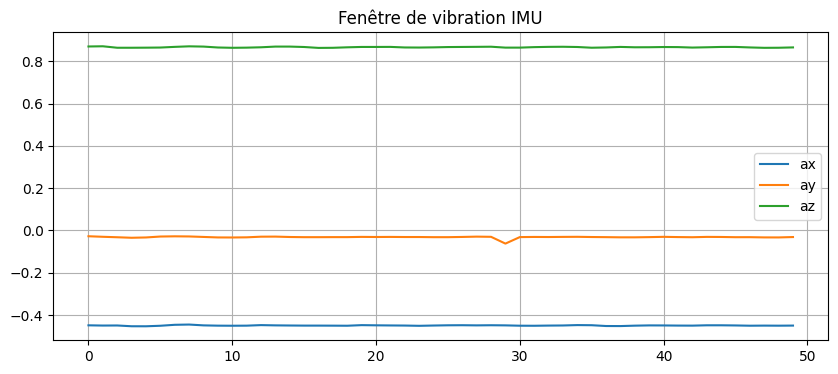

In [284]:
plt.figure(figsize=(10,4))
plt.plot(Xw[0][:,0], label="ax")
plt.plot(Xw[0][:,1], label="ay")
plt.plot(Xw[0][:,2], label="az")
plt.title("Fenêtre de vibration IMU")
plt.legend()
plt.grid()
plt.show()


4️⃣ Split Train / Test

In [285]:
# 🔴 APLATISSEMENT AVANT LE MODELE
X_flat = X_scaled.reshape(X_scaled.shape[0], WINDOW_SIZE * N_FEATURES)


X_train, X_test, y_train, y_test = train_test_split(
    X_flat, yw, test_size=0.2, random_state=42
)


5️⃣ Modèle TinyML (clé du projet)
Modèle volontairement compact pour une exécution embarquée.

In [286]:
N_CLASSES = 3

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(150,)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(N_CLASSES, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                │ (None, 32)             │         4,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,931 (19.26 KB)

 Trainable params: 4,931 (19.26 KB)

 Non-trainable params: 0 (0.00 B)

6️⃣ Entraînement

In [287]:
model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9671 - loss: 0.1148 - val_accuracy: 1.0000 - val_loss: 0.0039
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 9.6769e-04
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 1.0000 - loss: 7.8740e-04 - val_accuracy: 1.0000 - val_loss: 6.2730e-04
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 5.3173e-04 - val_accuracy: 1.0000 - val_loss: 4.4196e-04
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.8498e-04 - val_accuracy: 1.0000 - val_loss: 3.2839e-04
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 2.9219e-04 - val_accuracy: 1.0000 - val_loss: 2.5444e-04
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 

7️⃣ Graphes d’apprentissage (OBLIGATOIRES)

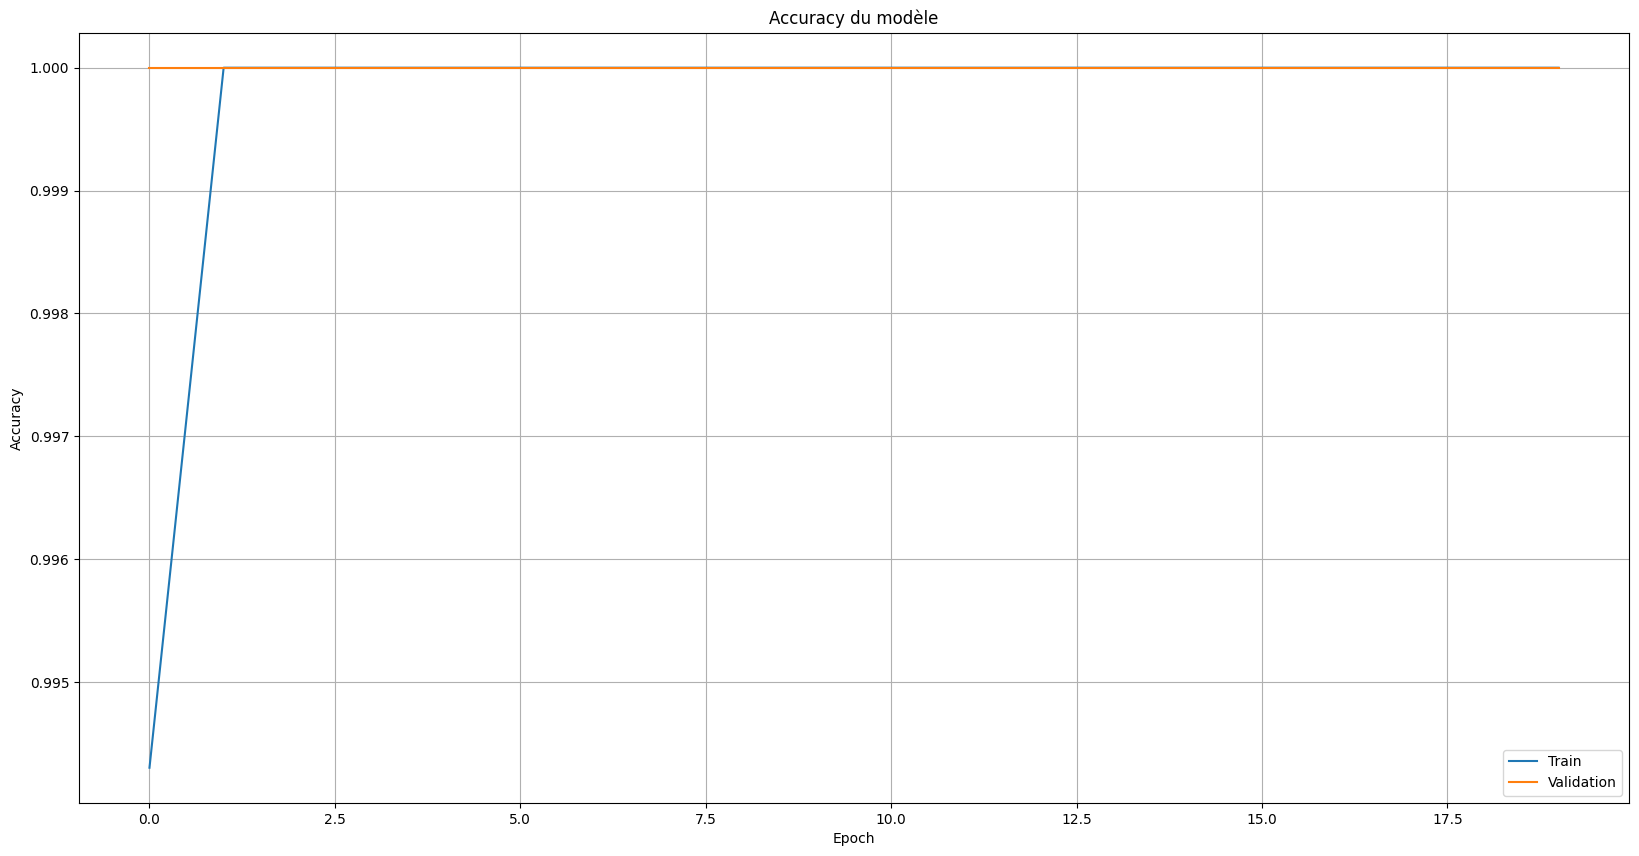

In [288]:
## Accuracy
plt.figure()
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("Accuracy du modèle")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


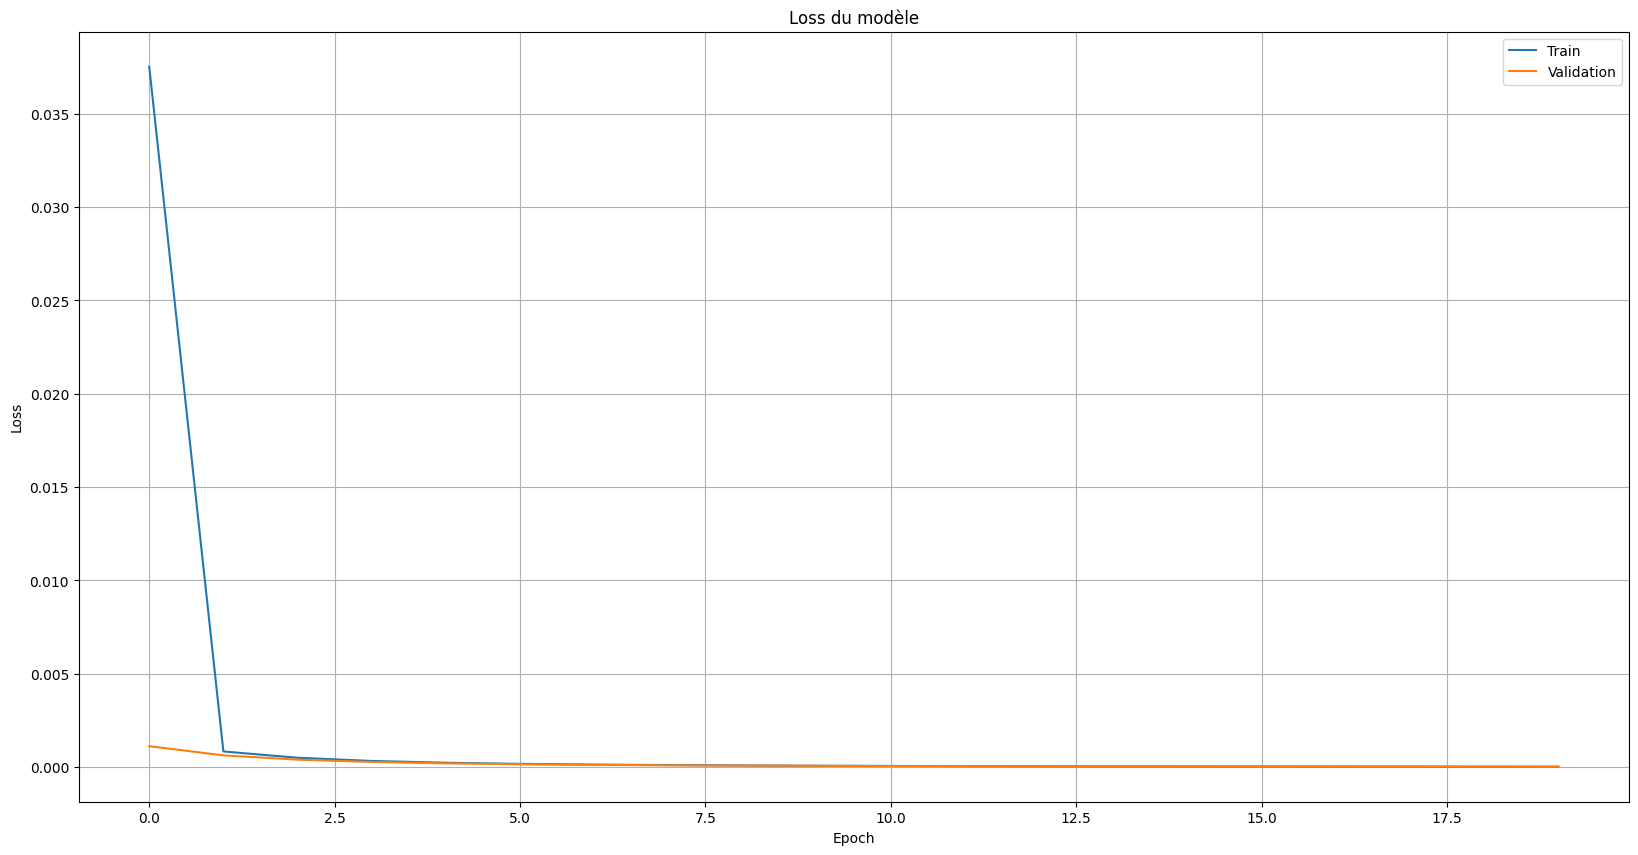

In [289]:
## Loss
plt.figure()
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Loss du modèle")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


8️⃣ Évaluation

In [290]:
loss, acc = model.evaluate(X_test, y_test)
print("Accuracy test :", acc)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.8966e-05 
Accuracy test : 1.0


9️⃣ Conversion TensorFlow Lite (INT8)

In [291]:
"""converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS_INT8
]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

def representative_dataset():
    for i in range(100):
        yield [X_train[i:i+1].astype("float32")]

converter.representative_dataset = representative_dataset

tflite_model = converter.convert()
"""
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = []
tflite_model = converter.convert()

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\papao\AppData\Local\Temp\tmpr7yxu97w\assets


INFO:tensorflow:Assets written to: C:\Users\papao\AppData\Local\Temp\tmpr7yxu97w\assets


Saved artifact at 'C:\Users\papao\AppData\Local\Temp\tmpr7yxu97w'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150), dtype=tf.float32, name='keras_tensor_59')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2299227225104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2299227214896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2299227223344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2299285253536: TensorSpec(shape=(), dtype=tf.resource, name=None)
INFO:tensorflow:Assets written to: C:\Users\papao\AppData\Local\Temp\tmpopug69dg\assets


INFO:tensorflow:Assets written to: C:\Users\papao\AppData\Local\Temp\tmpopug69dg\assets


Saved artifact at 'C:\Users\papao\AppData\Local\Temp\tmpopug69dg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150), dtype=tf.float32, name='keras_tensor_59')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2299227225104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2299227214896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2299227223344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2299285253536: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [292]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

for d in interpreter.get_tensor_details():
    print(d["name"], d["dtype"])


serving_default_keras_tensor_59:0 <class 'numpy.float32'>
arith.constant <class 'numpy.float32'>
arith.constant1 <class 'numpy.float32'>
sequential_16_1/dense_32_1/MatMul <class 'numpy.float32'>
sequential_16_1/dense_32_1/Relu;sequential_16_1/dense_32_1/BiasAdd <class 'numpy.float32'>
sequential_16_1/dense_32_1/MatMul;sequential_16_1/dense_32_1/Relu;sequential_16_1/dense_32_1/BiasAdd <class 'numpy.float32'>
sequential_16_1/dense_33_1/MatMul;sequential_16_1/dense_33_1/BiasAdd <class 'numpy.float32'>
StatefulPartitionedCall_1:0 <class 'numpy.float32'>


c:\Users\papao\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


🔟 Sauvegarde du modèle

In [293]:
with open("../models/vibration_model.tflite", "wb") as f:
    f.write(tflite_model)


1️⃣1️⃣ Conversion en .h (léger)

In [294]:
with open("../models/vibration_model.tflite", "rb") as f:
    model_bytes = f.read()

with open("../../3-Inference_Arduino/inference_vibrations/vibration_model.h", "w") as f:
    f.write("const unsigned char vibration_model[] = {\n")
    f.write(",".join(str(b) for b in model_bytes))
    f.write("\n};\n")
    f.write(f"const unsigned int vibration_model_len = {len(model_bytes)};")

with open("../models/vibration_model.h", "w") as f:
    f.write("const unsigned char vibration_model[] = {\n")
    f.write(",".join(str(b) for b in model_bytes))
    f.write("\n};\n")
    f.write(f"const unsigned int vibration_model_len = {len(model_bytes)};")
    
# Afficher la taille du fichier généré
import os
model_h_size = os.path.getsize("../../3-Inference_Arduino/inference_vibrations/vibration_model.h")
print(f"✅ Fichier header créé avec succès !")
print(f"📄 Taille du fichier model.h : {model_h_size:,} bytes ({model_h_size/1024:.2f} KB)")
print(f"\n📋 Prochaines étapes :")
print(f"   1. Ouvrez le fichier model.h dans votre éditeur")
print(f"   2. Ajoutez-le comme onglet dans votre sketch Arduino")
print(f"   3. Utilisez-le avec TensorFlow Lite for Microcontrollers")

✅ Fichier header créé avec succès !
📄 Taille du fichier model.h : 74,233 bytes (72.49 KB)

📋 Prochaines étapes :
   1. Ouvrez le fichier model.h dans votre éditeur
   2. Ajoutez-le comme onglet dans votre sketch Arduino
   3. Utilisez-le avec TensorFlow Lite for Microcontrollers
